# Import Libraries

In [1]:
%matplotlib inline


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [2]:
(x_train,y_train),(x_test ,y_test)=tf.keras.datasets.mnist.load_data()

# Plot Examples

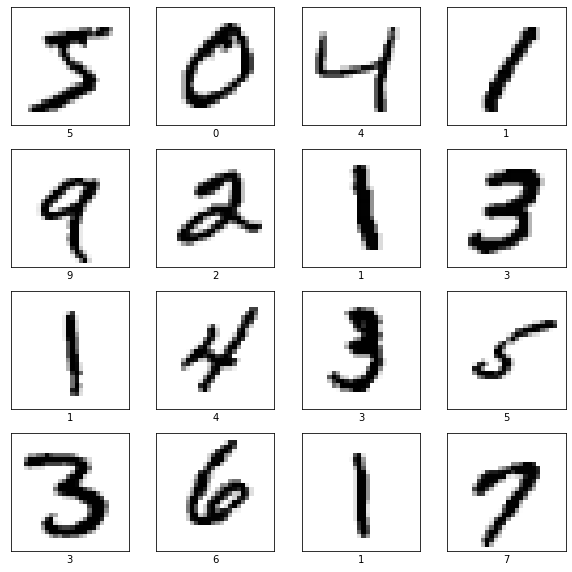

In [3]:
plt.figure(figsize=(10,10))

for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i],cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Normalize Data

In [4]:
x_train=np.reshape(x_train,(60000,28*28))
x_test=np.reshape (x_test,(10000,28*28))
x_train=x_train/255.
x_test=x_test/255.

# Create a Neural Network Model

In [5]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,activation='sigmoid',input_shape=(784,)),
    tf.keras.layers.Dense(32,activation='sigmoid'),
    tf.keras.layers.Dense(32,activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train the Model

In [7]:
_=model.fit(x_train,y_train,
          validation_data=(x_test,y_test),
          epochs=100,batch_size=2048,
          verbose=1)

Epoch 1/100
30/30 [==============================] - 1s 23ms/step - loss: 0.0981 - accuracy: 0.9742 - val_loss: 0.1382 - val_accuracy: 0.9579
Epoch 2/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0970 - accuracy: 0.9745 - val_loss: 0.1372 - val_accuracy: 0.9583
Epoch 3/100
30/30 [==============================] - 1s 22ms/step - loss: 0.0959 - accuracy: 0.9749 - val_loss: 0.1368 - val_accuracy: 0.9588
Epoch 4/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0949 - accuracy: 0.9750 - val_loss: 0.1361 - val_accuracy: 0.9590
Epoch 5/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0938 - accuracy: 0.9754 - val_loss: 0.1355 - val_accuracy: 0.9591
Epoch 6/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0929 - accuracy: 0.9757 - val_loss: 0.1345 - val_accuracy: 0.9587
Epoch 7/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0918 - accuracy: 0.9759 - val_loss: 0.1343 - val_accuracy: 0.9593
Epoch 

# Save the Model

In [8]:
model.save('model.h5')

# ML Server

In [9]:

%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask ,request

app=Flask(__name__)

model =tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
model.inputs,[
    layer.output for layer in model.layers]
)
_,(x_test,_)=tf.keras.datasets.mnist.load_data()
x_test = x_test/255.

def get_prediction():
    index=np.random.choice(x_test.shape[0])
    image=x_test[index,:,:]
    image_arr=np.reshape(image,(1,784))
    return feature_model.predict(image_arr),image

@app.route('/',methods=['GET','POST'])         
def index():
    if request.method =='POST':
        preds,image=get_prediction()
        final_preds=[p.tolist() for p in preds]
        return json.dumps({
            'prediction':final_preds,
            'image':image.tolist()
        })
    return 'Welcome to the model'

if __name__=='__main__':
    app.run()

Overwriting ml_server.py


# Streamlit Web App

In [10]:
%%writefile app.py

import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URI='http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('## INPUT IMAGE')

if st.button('GEt random prediction'):
    response =requests.post(URI,data={})
    response =json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image,(28,28))
    
    st.image(image,width=150)
    for layer, p in enumerate(preds):
        numbers =np.squeeze(np.array(p))
        
        plt.figure(figsize=(32,4))
        if layer == 2:
            row=1
            col=10
        else:
            row=2
            col=16
        
        for i,number in enumerate(numbers):
            plt.subplot(row,col,i+1)
            plt.imshow(number*np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            
            if layer ==2:
                plt.xlabel(str(i),fontsize=40)
                
        plt.subplots_adjust(wspace=0.05,hspace=0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer+1))
        st.pyplot()
        
            
            
            

Overwriting app.py
